In [52]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
from rdkit.Chem import AllChem, MolFromSmiles
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit.Chem import DataStructs
from rdkit import Chem
from rxnfp.tokenization import get_default_tokenizer, SmilesTokenizer
from rdkit.Chem import rdChemReactions
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

In [53]:
import MLR_utils
from MLR_utils import plot_three_features, drop_corr_features, linear_reg_of_n_features, evaluate_model_of_n_features 
from MLR_utils import all_features, combination_any_2_features, combination_groupof2_with_1feat, comb2feats_MLR_evaby_crossval
from MLR_utils import comb3feats_MLR_evaby_crossval, fold_5_cross_validation, fold_5_cross_validation_for_stream
from MLR_utils import feats_evaby_crossval_5nfold, linear_and_plot_yield_vs_ypred, comb3feats_MLR_evaby_crossval_metric

In [54]:
#Data processing
#df_origin = pd.read_excel('Afterscreen.xlsx', sheet_name='Result2')
df_origin = pd.read_excel('C:/Users/Ran Tao/Desktop/temp/Afterscreen.xlsx', sheet_name='Result2')
df_origin = df_origin.sample(frac=1,random_state=41)
# Reindex the data with column ID
df_origin = df_origin.set_index('ID')
# remove row 157
df_origin = df_origin.drop([157])

df_x = df_origin.drop(columns = ['Yield-avg','SMILES','ligand','buch','Unnamed: 0'])
#df_x = df_x.drop(columns = ['x198','x199','x200','x201','x202','Unnamed: 110'])
df_y = df_origin[['Yield-avg']]


from sklearn.preprocessing import StandardScaler

In [55]:
df_result_1 = pd.read_excel('Afterscreen.xlsx', sheet_name='Result')
# in df_result_1 choose those with ID = 157, 308
df_dino_poo = df_result_1.loc[df_result_1['ID'].isin([157,308,465])]
# df_dino_poo drop column x214,x215
df_dino_poo = df_dino_poo.drop(columns = ['x214','x215'])
df_dino_poo.set_index('ID', inplace=True)
df_dino_poo

,Unnamed: 0,SMILES,ligand,label,Yield-avg,buch,x1,x2,x3,x4,...,x201,x202,x203,x204,x205,x206,x207,x208,x209,x213
ID,,,,,,,,,,,,,,,,,,,,,
157,152,CC(C)(C)c1cc(P(c2cc(C(C)(C)C)cc(C(C)(C)C)c2)C2...,"PCyp(3,5-tBu2-Ph)2",DinoPhos,99.0,NaN,-0.057132,1.825000,-0.222075,-0.021239,...,8.717660,7.918274,10.272581,2.354307,28.472683,25.922363,31.63322,5.710857,28,517.672475
308,301,C[C@@H]1CC[C@@H](C)P1c1ccccc1C1OCCO1,(2-dioxolanePh) Me2Phospholane,Diphenyl,92.5,NaN,-0.053024,1.798927,-0.227121,-0.026063,...,11.081421,8.294548,15.077067,6.782519,10.452172,6.931763,17.14101,10.209246,15,220.650131
465,1,CCCP(C1=CC=CC=C1)C2=CC=CC=C2,PPh2nPr,Diphenyl,53.0,NaN,-0.051866,1.840500,-0.228866,-0.028311,...,8.063909,7.616105,8.409237,0.793132,10.891981,10.077378,11.38579,1.308412,7,219.998872


In [56]:
df_kraken = pd.read_excel('krakendesc_withvisvol.xlsx',sheet_name='DFT_data_training')
df_kraken.dropna(inplace=True)
kraken_ID = df_kraken[['ID','SMILES']]
df_kraken_remove_functionality = pd.read_excel('krakendesc_withvisvol.xlsx',sheet_name='DFT_remove_functionality')
df_kraken_remove_functionality.dropna(inplace=True)
df_kraken_remove_functionality_ID = df_kraken_remove_functionality[['ID','SMILES','label']]
df_kraken_remove_functionality = df_kraken_remove_functionality.drop(columns = ['label','SMILES','ID','Unnamed: 0','x214','x215'])

In [57]:
# shared column between df_kraken and df_origin
shared_col = df_kraken.columns.intersection(df_origin.columns)
print(shared_col)

Index(['Unnamed: 0', 'SMILES', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8',
       ...
       'x201', 'x202', 'x203', 'x204', 'x205', 'x206', 'x207', 'x208', 'x209',
       'x213'],
      dtype='object', length=215)


In [58]:
df_origin = df_origin.sort_values(by=['ID'])

In [59]:
df_x_problem = df_origin.drop(columns = ['Yield-avg','SMILES','ligand','buch','Unnamed: 0'])
df_y_problem = df_origin[['Yield-avg']]
df_x_problem = df_kraken.loc[df_kraken['ID'].isin(df_origin.index)]
shared_column = df_x_problem.columns.intersection(df_kraken_remove_functionality.columns)
df_kraken_remove_functionality = df_kraken_remove_functionality[shared_column]
df_dino_poo_modeling = df_dino_poo.drop(columns = ['Yield-avg','SMILES','ligand','buch','Unnamed: 0','label'])

splitting = 0.8
random_state = 43
# sort by id
df_x_problem = df_x_problem.sort_values(by='ID')
df_x_problem = df_x_problem.set_index('ID')
df_x_problem = df_x_problem.drop(columns = ['SMILES','x214','x215','Unnamed: 0'])
df_x_problem = df_x_problem.sample(frac=1,random_state=random_state)
df_y_problem = df_y_problem.sample(frac=1,random_state=random_state)
train_x_problem_pure = df_x_problem[:(int((len(df_x_problem)*splitting)))]
test_x_problem = df_x_problem[(int((len(df_x_problem)*splitting))):]
train_y = df_y_problem[:(int((len(df_y_problem)*splitting)))]
test_y = df_y_problem[(int((len(df_y_problem)*splitting))):]

scaler = StandardScaler(-3,3)
kraken_scalar = df_kraken.drop(columns = ['SMILES','ID','x214','x215','Unnamed: 0'])
kraken_scalar = pd.DataFrame(scaler.fit_transform(kraken_scalar),index=kraken_scalar.index, columns=kraken_scalar.columns)
train_x_problem=pd.DataFrame(scaler.transform(train_x_problem_pure),index=train_x_problem_pure.index, columns=train_x_problem_pure.columns)
test_x_problem = pd.DataFrame(scaler.transform(test_x_problem),index=test_x_problem.index, columns=test_x_problem.columns)
df_x_problem = pd.DataFrame(scaler.transform(df_x_problem),index=df_x_problem.index, columns=df_x_problem.columns)
df_kraken_remove_functionality = pd.DataFrame(scaler.transform(df_kraken_remove_functionality),index=df_kraken_remove_functionality.index, columns=df_kraken_remove_functionality.columns)
df_dino_poo_modeling = pd.DataFrame(scaler.transform(df_dino_poo_modeling),index=df_dino_poo_modeling.index, columns=df_dino_poo_modeling.columns)

"""
df_origin = pd.read_excel('Afterscreen.xlsx', sheet_name='Result2')
# sort by id
df_origin = df_origin.sort_values(by='ID')

df_x = df_origin.drop(columns = ['Yield-avg','SMILES','ligand','buch','ID','Unnamed: 0'])
#df_x = df_x.drop(columns = ['x198','x199','x200','x201','x202','Unnamed: 110'])
df_y = df_origin[['Yield-avg']]


train_x_pure = df_x[:(int((len(df_x)*splitting)))]
test_x = df_x[(int((len(df_x)*splitting))):]
train_y = df_y[:(int((len(df_y)*splitting)))]
test_y = df_y[(int((len(df_y)*splitting))):]

scaler = StandardScaler()
train_x=pd.DataFrame(scaler.fit_transform(train_x_pure),index=train_x_pure.index, columns=train_x_pure.columns)
test_x=pd.DataFrame(scaler.transform(test_x),index=test_x.index, columns=test_x.columns)
df_x = pd.DataFrame(scaler.transform(df_x),index=df_x.index, columns=df_x.columns)
"""
#validation_ID = [18,65,73,80,130,232,252,351,465,735,767,799]
#validation_ID = [18,65,73,80,232,252,735,767,799]
validation_ID = [18,65,73,80,130,232,252,351,465,767]
df_validation = df_kraken.loc[df_kraken['ID'].isin(validation_ID)]
df_validation.set_index('ID',inplace=True)
#df_validation['yvalid'] = [34,71,10.5,3,0,31,0,35,0]
#df_validation['yvalid'] = [34,71,10.5,3,37,0,31,44.5,53,0,35,0]
df_validation['yvalid'] = [34,71,10.5,3,37,0,31,44.5,53,35]
df_validation.sort_index(inplace=True)
df_y_valid = df_validation['yvalid']

df_validation = df_validation.drop(columns = ['SMILES','yvalid','x214','x215','Unnamed: 0'])
df_validation=pd.DataFrame(scaler.transform(df_validation),index=df_validation.index, columns=df_validation.columns)
#df_validation_fititself = pd.DataFrame(scaler.fit_transform(df_validation),index=df_validation.index, columns=df_validation.columns)
# remove ligand 465 from df_validation

C:\Users\Ran Tao\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass copy=-3, with_mean=3 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
c:\Users\Ran Tao\.conda\envs\edbo\lib\site-packages\ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [60]:
df_validation_full = pd.read_excel('Afterscreen.xlsx', sheet_name='Validation_full')
df_validation_full.sort_values(by='ID',inplace=True)
df_y_valid_full = df_validation_full['Yield-avg']
df_validation_full_train = df_kraken.loc[df_kraken['ID'].isin(df_validation_full['ID'])]
df_validation_full_train.set_index('ID',inplace=True)
df_validation_full_train = df_validation_full_train.drop(columns = ['SMILES','x214','x215','Unnamed: 0'])
df_validation_full_train=pd.DataFrame(scaler.transform(df_validation_full_train),index=df_validation_full_train.index, columns=df_validation_full_train.columns)
print(df_validation_full_train.shape)

(9, 213)


In [61]:
df_buchwald = pd.read_excel('Buchwald_Screen.xlsx', sheet_name='Sheet1')


In [62]:
df_buchwald.sort_values(by='ID',inplace=True)
df_y_buchwald = df_buchwald['Yield-avg']
df_buchwald_train = df_kraken.loc[df_kraken['ID'].isin(df_buchwald['ID'])]
df_buchwald_train.set_index('ID',inplace=True)
df_buchwald_train = df_buchwald_train.drop(columns = ['SMILES','x214','x215','Unnamed: 0'])
df_buchwald_train=pd.DataFrame(scaler.transform(df_buchwald_train),index=df_buchwald_train.index, columns=df_buchwald_train.columns)

Coefficients: 
 [[-19.0121365  -12.6015246  -47.04759627  10.12990399]]
Intercept: 
 [10.75524163]
Train mse: 45.30 Test mse: 151.43
Train r2: 0.92 Test r2: 0.76
Valid mse: 876.81 Valid r2: -3.66
Valid_full mse: 193.97 Valid_full r2: -0.84
Overall mse: 1458.97
Overall r2: -1.50


c:\Users\Ran Tao\.conda\envs\edbo\lib\site-packages\ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\Ran Tao\.conda\envs\edbo\lib\site-packages\ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\Ran Tao\.conda\envs\edbo\lib\site-packages\ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

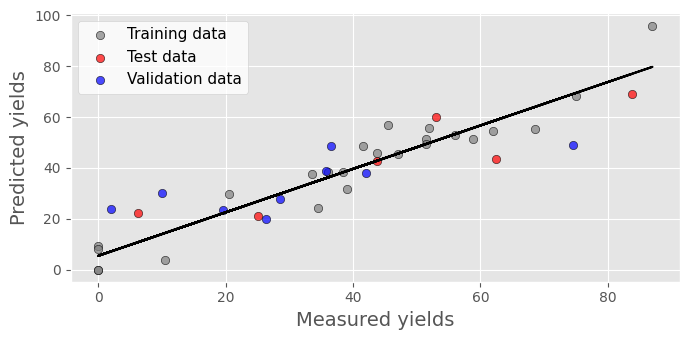

In [80]:
#feats = ['x33', 'x83', 'x23', 'x18', 'x102']
#feats = ['x1', 'x77', 'x100', 'x33', 'x31']
#feats = ['x33', 'x83', 'x23','x102']
feats = ['x32', 'x83', 'x23','x102']
#feats = ['x32', 'x99', 'x23','x183']
#feats = ['x1', 'x77',  'x33', 'x31']
#feats = ['x1','x100','x184','x14']
train_3x = train_x_problem[feats]
test_3x= test_x_problem[feats]
df_3f = df_x_problem[feats]
df_valid_3 = df_validation[feats]
df_valid_full_3 = df_validation_full_train[feats] 
kraken_scalar_3 = kraken_scalar[feats]
df_kraken_remove_functionality_3 = df_kraken_remove_functionality[feats]
df_dino_poo_3 = df_dino_poo_modeling[feats]
df_buchwald_3 = df_buchwald_train[feats]

regg=linear_model.LinearRegression(normalize=True)     #initiating linearregression
model = regg.fit(train_3x,train_y)
print('Coefficients: \n', model.coef_)
print('Intercept: \n', model.intercept_)
         
train_y_pred = model.predict(train_3x)
test_y_pred = model.predict(test_3x)
df_ypred= model.predict(df_3f)
df_ypred_valid= model.predict(df_valid_3)
df_ypred_valid_full= model.predict(df_valid_full_3)
df_ypred_kraken_scalar = model.predict(kraken_scalar_3)
df_ypred_kraken_remove_functionality = model.predict(df_kraken_remove_functionality_3)
df_ypred_dino_poo = model.predict(df_dino_poo_3)
df_ypred_buchwald = model.predict(df_buchwald_3)
    
intercept, coeff, yypred = linear_reg_of_n_features(df_y_problem,df_ypred)
    
    # capping
    # df_ypred小于0的值设为0
df_ypred[df_ypred<0]=0
train_y_pred    [train_y_pred<0]=0
test_y_pred[test_y_pred<0]=0
df_ypred_valid[df_ypred_valid<0]=0
df_ypred_valid_full[df_ypred_valid_full<0]=0
df_ypred_buchwald[df_ypred_buchwald<0]=0
    # df_ypred大于100的值设为100
df_ypred[df_ypred>100]=100
train_y_pred    [train_y_pred>100]=100
test_y_pred[test_y_pred>100]=100
df_ypred_valid[df_ypred_valid>100]=100
df_ypred_valid_full[df_ypred_valid_full>100]=100
df_ypred_buchwald[df_ypred_buchwald>100]=100

train_mse="{:.2f}".format(mean_squared_error(train_y, train_y_pred))
test_mse="{:.2f}".format(mean_squared_error(test_y, test_y_pred))
print('Train mse:',train_mse,'Test mse:',test_mse)
train_r2="{:.2f}".format(r2_score(train_y, train_y_pred))
test_r2="{:.2f}".format(r2_score(test_y, test_y_pred))
print('Train r2:',train_r2,'Test r2:',test_r2)
valid_mse="{:.2f}".format(mean_squared_error(df_ypred_valid, df_y_valid))
valid_r2 = "{:.2f}".format(r2_score(df_ypred_valid, df_y_valid))
print('Valid mse:',valid_mse,'Valid r2:',valid_r2)
valid_full_mse="{:.2f}".format(mean_squared_error(df_ypred_valid_full, df_y_valid_full))
valid_full_r2 = "{:.2f}".format(r2_score(df_ypred_valid_full, df_y_valid_full))
print('Valid_full mse:',valid_full_mse,'Valid_full r2:',valid_full_r2)
   
mse_bestfit="{:.2f}".format(mean_squared_error(df_y,df_ypred))
print('Overall mse:',mse_bestfit)
r2_bestfit="{:.2f}".format(r2_score(df_y,df_ypred))
print('Overall r2:',r2_bestfit)

    
plt.style.use('default')
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(7, 3.5))
    
df_3f['y_pred'] = df_ypred
df_3f['y']=df_y
df_3f['diff']=abs(df_3f['y_pred']-df_3f['y'])
df_3f = df_3f.sort_values(by='diff',ascending=False)

    #list1=list(range(0,100))
    #ax.plot(list1, list1, color='k', label='Accurate prediction')
ax.plot(df_y,df_y*coeff+intercept, color = 'k')
ax.scatter(train_y,train_y_pred, edgecolor='k', facecolor='grey', alpha=0.7, label='Training data')
ax.scatter(test_y,test_y_pred, edgecolor='k', facecolor='red', alpha=0.7, label='Test data')
#ax.scatter(df_y_valid,df_ypred_valid, edgecolor='k', facecolor='yellow', alpha=0.7, label='Validation data')
ax.scatter(df_y_valid_full,df_ypred_valid_full, edgecolor='k', facecolor='blue', alpha=0.7, label='Validation data')
ax.set_ylabel('Predicted yields', fontsize=14)
ax.set_xlabel('Measured yields', fontsize=14)
ax.legend(facecolor='white', fontsize=11)
        #ax.text(0.55, 0.15, '$y = %.2f x_1 - %.2f $' % (model.coef_[0], abs(model.intercept_)), fontsize=17, transform=ax.transAxes)

fig.tight_layout()

In [81]:
df_ypred_valid_full

array([[48.63810409],
       [23.51626398],
       [49.16190546],
       [30.1468609 ],
       [23.64597388],
       [38.91876455],
       [19.98402341],
       [38.12403421],
       [27.75231827]])

In [82]:
df_y_valid_full

0    36.5
1    19.5
2    74.5
3    10.0
4     2.0
5    35.7
6    26.3
7    42.0
8    28.5
Name: Yield-avg, dtype: float64

Train mse: 45.30 Test mse: 151.43
Train r2: 0.92 Test r2: 0.76
Valid mse: 876.81 Valid r2: -3.66
Valid_full mse: 193.97 Valid_full r2: -0.84
Overall mse: 1458.97
Overall r2: -1.50


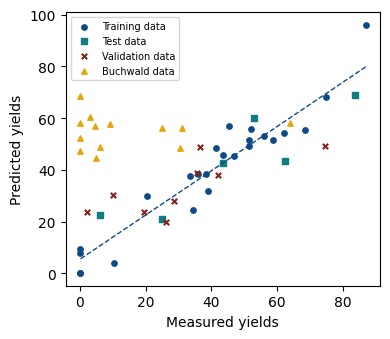

In [83]:
train_mse="{:.2f}".format(mean_squared_error(train_y, train_y_pred))
test_mse="{:.2f}".format(mean_squared_error(test_y, test_y_pred))
print('Train mse:',train_mse,'Test mse:',test_mse)
train_r2="{:.2f}".format(r2_score(train_y, train_y_pred))
test_r2="{:.2f}".format(r2_score(test_y, test_y_pred))
print('Train r2:',train_r2,'Test r2:',test_r2)
valid_mse="{:.2f}".format(mean_squared_error(df_ypred_valid, df_y_valid))
valid_r2 = "{:.2f}".format(r2_score(df_ypred_valid, df_y_valid))
print('Valid mse:',valid_mse,'Valid r2:',valid_r2)
valid_full_mse="{:.2f}".format(mean_squared_error(df_ypred_valid_full, df_y_valid_full))
valid_full_r2 = "{:.2f}".format(r2_score(df_ypred_valid_full, df_y_valid_full))
print('Valid_full mse:',valid_full_mse,'Valid_full r2:',valid_full_r2)
   
mse_bestfit="{:.2f}".format(mean_squared_error(df_y,df_ypred))
print('Overall mse:',mse_bestfit)
r2_bestfit="{:.2f}".format(r2_score(df_y,df_ypred))
print('Overall r2:',r2_bestfit)

plt.rcdefaults()  


fig, ax = plt.subplots(figsize=(4, 3.5))
    
df_3f['y_pred'] = df_ypred
df_3f['y']=df_y
df_3f['diff']=abs(df_3f['y_pred']-df_3f['y'])
df_3f = df_3f.sort_values(by='diff',ascending=False)
    #list1=list(range(0,100))
    #ax.plot(list1, list1, color='k', label='Accurate prediction')

ax.scatter(train_y,train_y_pred,  s=15,facecolor='#104986', alpha=1, label='Training data')
ax.scatter(test_y,test_y_pred,  s=15,facecolor='#107e80', alpha=1, label='Test data',marker='s')
#ax.scatter(df_y_valid,df_ypred_valid, edgecolor='k', facecolor='yellow', alpha=0.7, label='Validation data')
ax.scatter(df_y_valid_full,df_ypred_valid_full,  s=15,facecolor='#81251c', alpha=1, label='Validation data',marker='x')
ax.scatter(df_y_buchwald,df_ypred_buchwald,  s=15,facecolor='#e6a50e', alpha=1, label='Buchwald data',marker='^')

ax.set_ylabel('Predicted yields')
ax.set_xlabel('Measured yields')
ax.legend(facecolor='white', fontsize=7)
        #ax.text(0.55, 0.15, '$y = %.2f x_1 - %.2f $' % (model.coef_[0], abs(model.intercept_)), fontsize=17, transform=ax.transAxes)
x = np.linspace(0, 100, 100)
df_y_problem_temp = df_y_problem.sort_values(by='Yield-avg',ascending=False)
ax.plot(df_y_problem_temp,df_y_problem_temp*coeff+intercept, color='#104986', linestyle='--', linewidth=1)
fig.tight_layout()

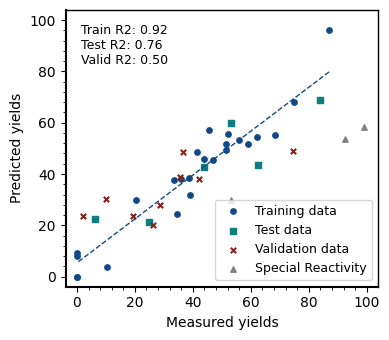

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import matplotlib.font_manager as font_manager

# 设置全局字体为 Helvetica
plt.rcParams['font.family'] = 'Helvetica'

# 假设 train_y, train_y_pred, test_y, test_y_pred, df_y_valid_full, df_ypred_valid_full
# 是已定义好的变量
# 假设 model.coef_ 和 model.intercept_ 也已经定义好

# 计算 R2 值
train_r2 = r2_score(train_y, train_y_pred)
test_r2 = r2_score(test_y, test_y_pred)
valid_r2 = r2_score(df_y_valid_full, df_ypred_valid_full)

fig, ax = plt.subplots(figsize=(4, 3.5))

# 绘制散点图
ax.scatter(train_y, train_y_pred, s=15, facecolor='#104986', alpha=1, label='Training data')
ax.scatter(test_y, test_y_pred, s=15, facecolor='#107e80', alpha=1, label='Test data', marker='s')
ax.scatter(df_y_valid_full, df_ypred_valid_full, s=15, facecolor='#81251c', alpha=1, label='Validation data', marker='x')
ax.scatter(df_dino_poo['Yield-avg'],df_ypred_dino_poo , s=15, facecolor='grey', alpha=1, label='Special Reactivity', marker='^')
#ax.scatter(df_y_buchwald,df_ypred_buchwald,  s=15,facecolor='#e6a50e', alpha=1, label='Buchwald data',marker='^')

# 设置边框宽度
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
ax.spines['top'].set_linewidth(1)    # 顶部边框较细
ax.spines['right'].set_linewidth(1) 

# 设置刻度间隔
ax.xaxis.set_major_locator(plt.MultipleLocator(20))
ax.xaxis.set_minor_locator(plt.MultipleLocator(4))
ax.yaxis.set_major_locator(plt.MultipleLocator(20))
ax.yaxis.set_minor_locator(plt.MultipleLocator(4))

# 设置图例和 R2 值的位置及字体大小
ax.legend(loc='lower right', facecolor='white', fontsize=9)
ax.text(0.05, 0.95, f'Train R2: {train_r2:.2f}\nTest R2: {test_r2:.2f}\nValid R2: {valid_r2:.2f}', 
       fontsize=9, verticalalignment='top', transform=ax.transAxes, ha='left')

# 设置轴标签
ax.set_xlabel('Measured yields')
ax.set_ylabel('Predicted yields')

# 绘制回归线
df_y_problem_temp = df_y_problem.sort_values(by='Yield-avg', ascending=False)
ax.plot(df_y_problem_temp, df_y_problem_temp * coeff + intercept, color='#104986', linestyle='--', linewidth=1)

# 设置坐标轴范围
ax.set_xlim(left=-3.9)
ax.set_ylim(bottom=-3.9, top=103.9) # Y 轴范围从 0 到 100

fig.tight_layout()
plt.show()



In [85]:
# train y and train y pred
df = pd.DataFrame({'Measured yields': train_y['Yield-avg'], 'Predicted yields': train_y_pred.flatten()})
df

,Measured yields,Predicted yields
ID,,
239,43.7,45.753247
79,39.0,31.888573
81,20.5,29.699299
57,10.5,3.812145
62,68.5,55.304977
68,51.5,51.557341
70,33.5,37.514155
171,45.5,57.028642
69,52.0,55.653312


In [86]:
# tesy y and test y pred
df = pd.DataFrame({'Measured yields': test_y['Yield-avg'], 'Predicted yields': test_y_pred.flatten()})
df

,Measured yields,Predicted yields
ID,,
162,62.50,43.489615
133,6.25,22.426885
199,53.00,59.994637
158,83.75,68.910290
11,43.70,42.557539
21,25.00,21.121193


In [87]:
df_validation_supply = df_validation
df_validation_supply['ypred_valid'] = df_ypred_valid
df_validation_supply['Yield-avg'] = df_y_valid

In [88]:
df_validation_supply.sort_values(by='Yield-avg',ascending=False,inplace=True)

c:\Users\Ran Tao\.conda\envs\edbo\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\Users\Ran Tao\.conda\envs\edbo\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
[14:03:12] Explicit valence for atom # 7 B, 6, is greater than permitted
c:\Users\Ran Tao\.conda\envs\edbo\lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:254: UserWarning: Truncating the lis

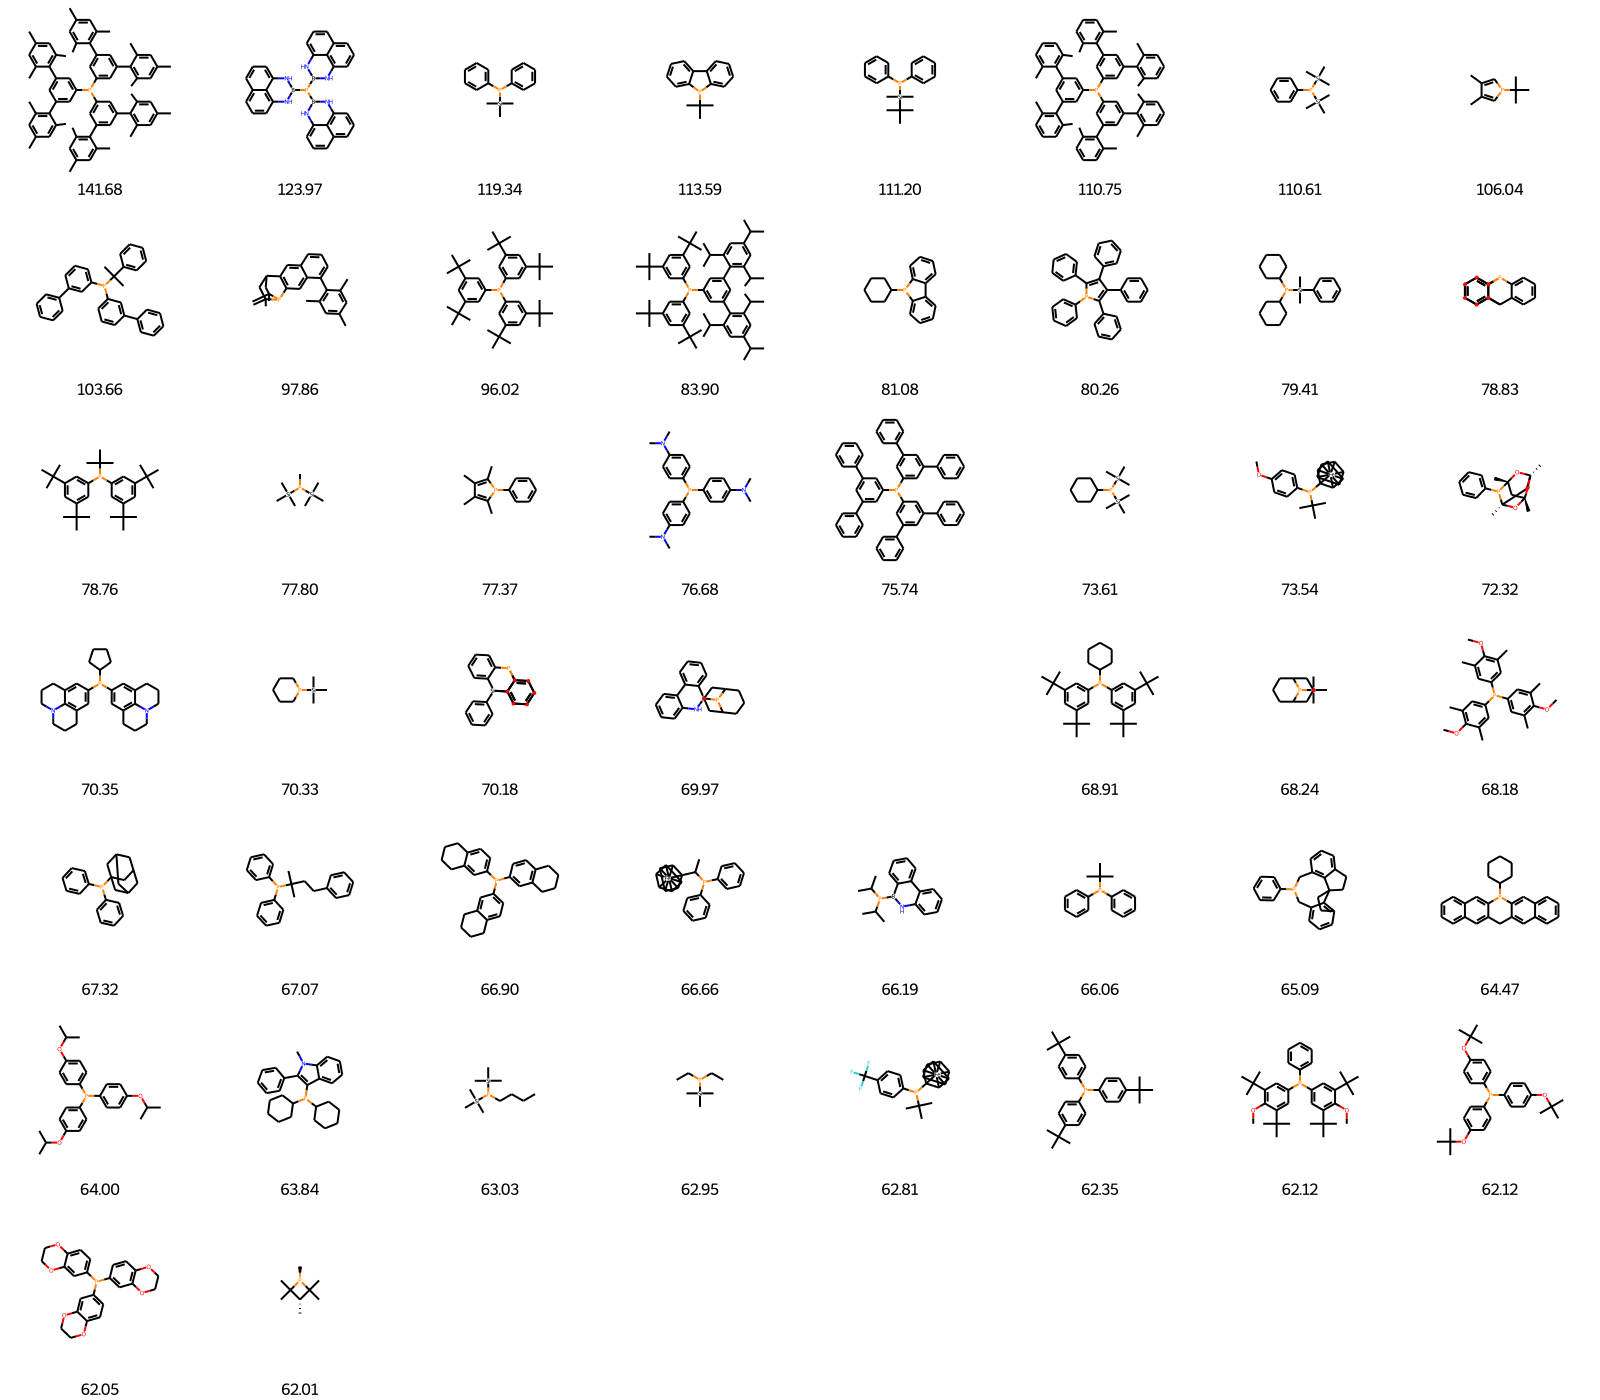

In [89]:
df_kraken_remove_functionality_3['y_pred'] = df_ypred_kraken_remove_functionality
df_kraken_remove_functionality_3[['ID','SMILES','label']] = df_kraken_remove_functionality_ID
df_kraken_remove_functionality_3=df_kraken_remove_functionality_3.sort_values(by='y_pred',ascending=False)
from rdkit.Chem import Draw
mols = [Chem.MolFromSmiles(smi) for smi in df_kraken_remove_functionality_3['SMILES']]
Draw.MolsToGridImage(mols, molsPerRow=8, subImgSize=(200, 200), legends=[f"{x:.2f}" for x in df_kraken_remove_functionality_3['y_pred']])

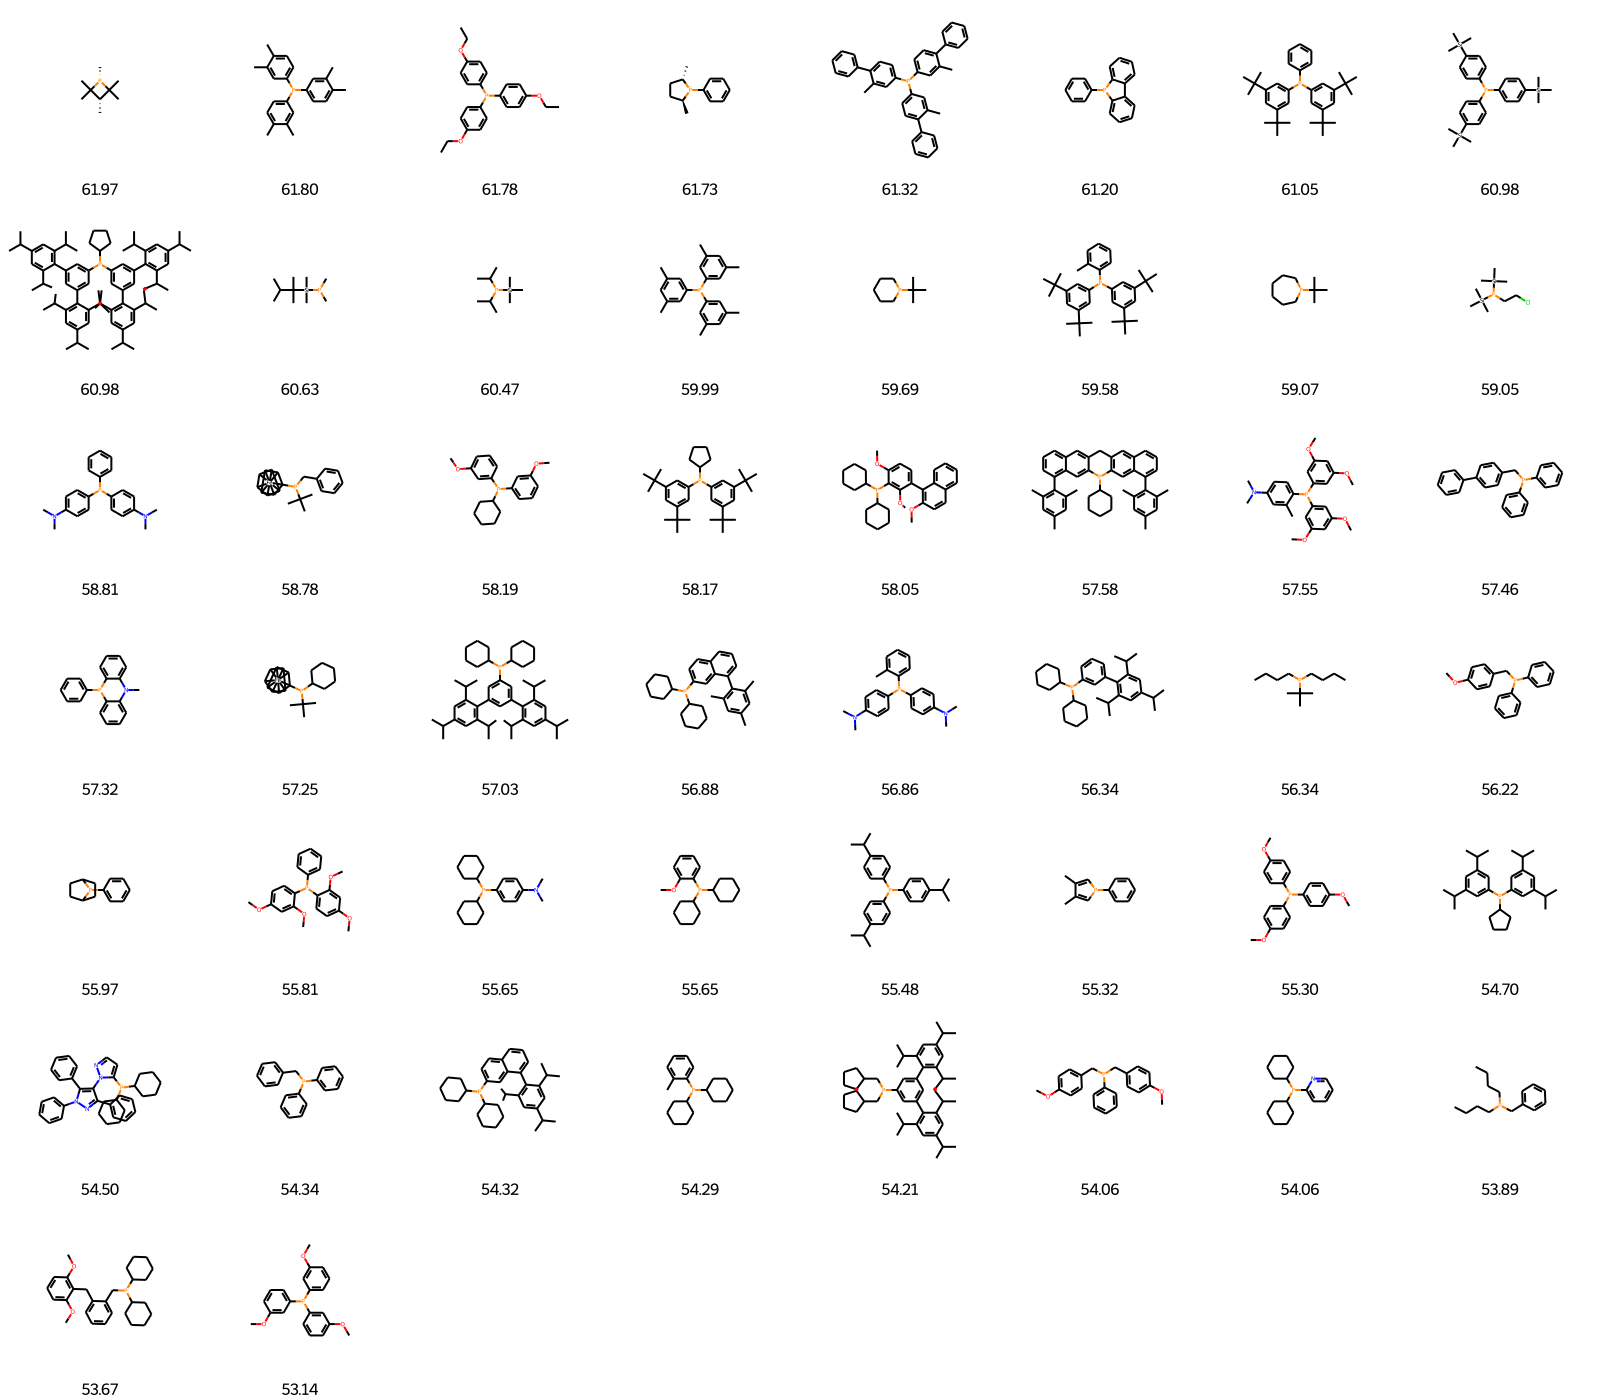

In [90]:
mols = [Chem.MolFromSmiles(smi) for smi in df_kraken_remove_functionality_3['SMILES'][50:]]
Draw.MolsToGridImage(mols, molsPerRow=8, subImgSize=(200, 200), legends=[f"{x:.2f}" for x in df_kraken_remove_functionality_3['y_pred'][50:]])

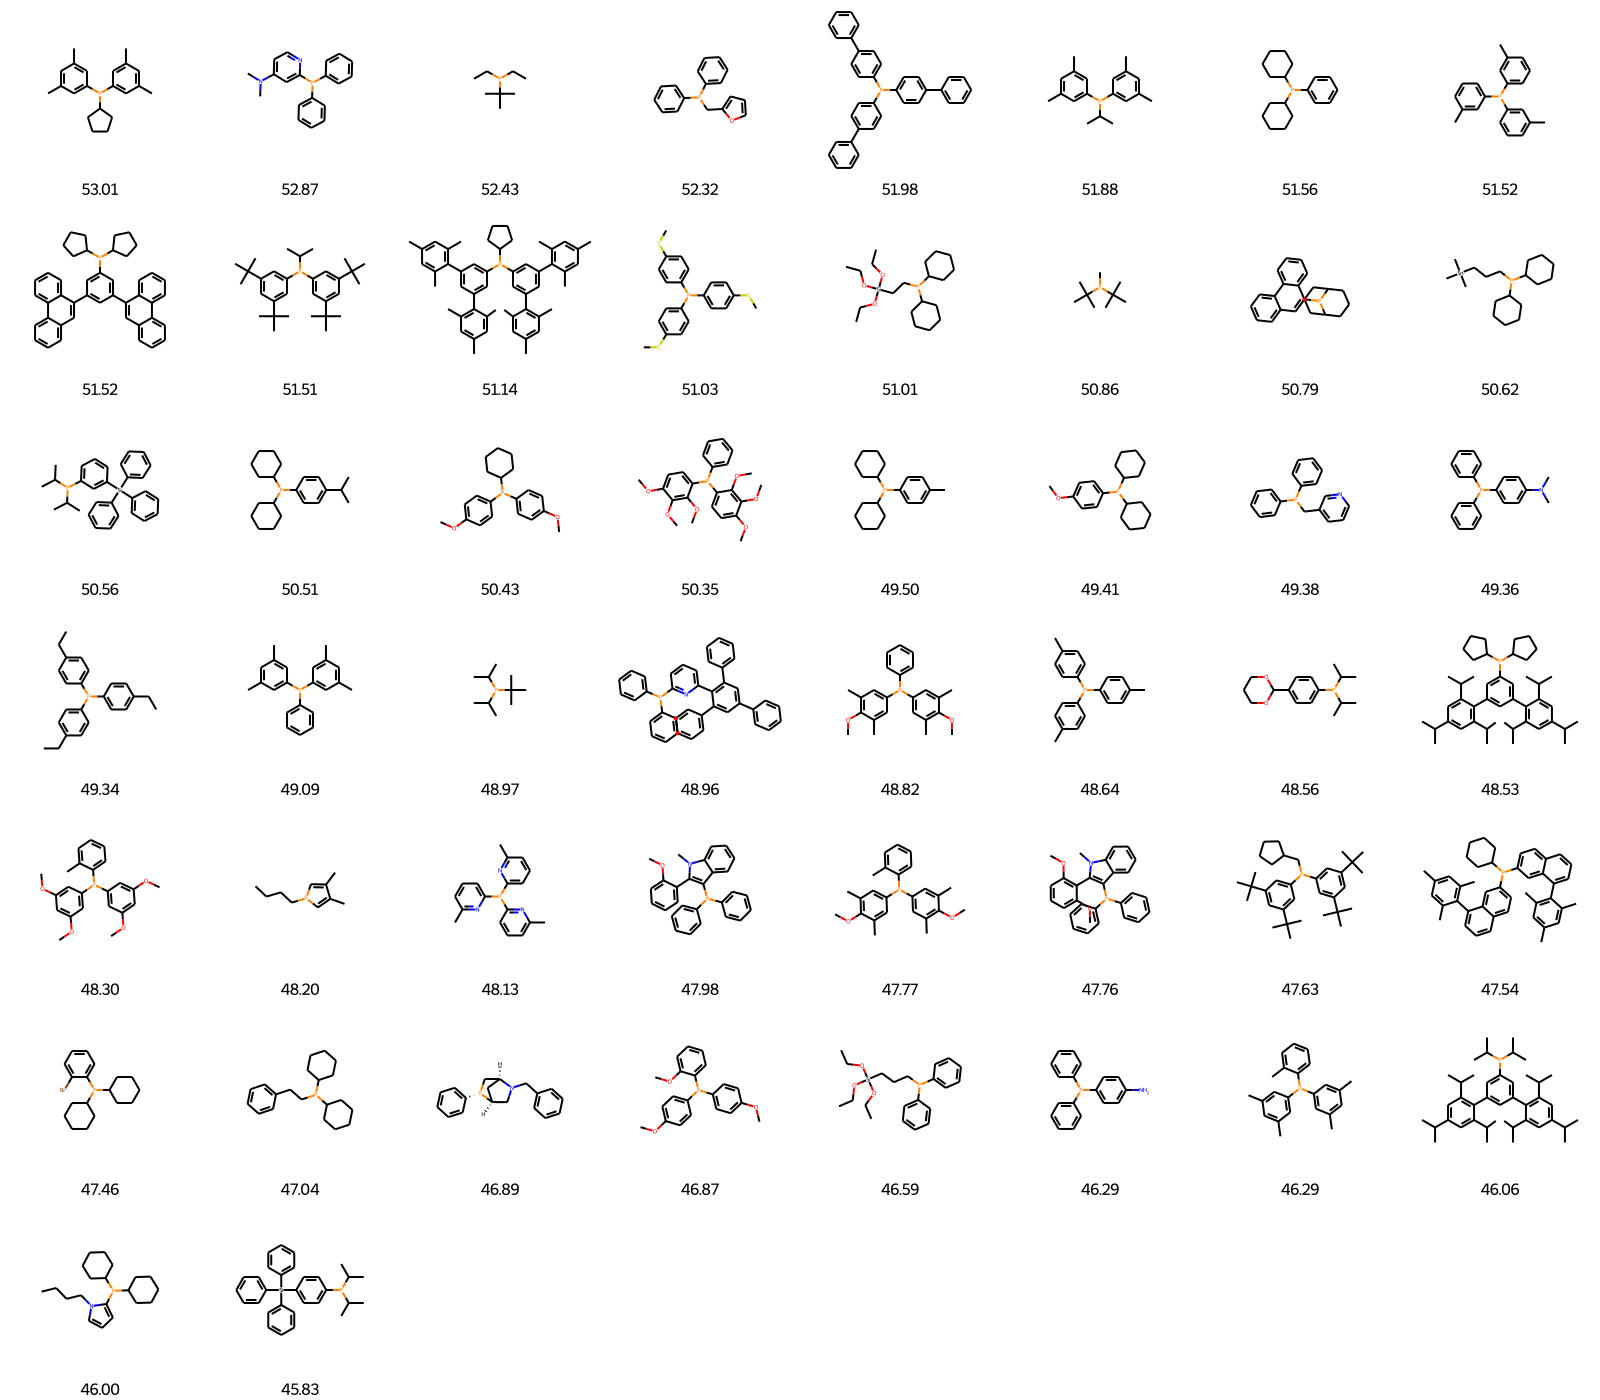

In [91]:
mols = [Chem.MolFromSmiles(smi) for smi in df_kraken_remove_functionality_3['SMILES'][100:]]
Draw.MolsToGridImage(mols, molsPerRow=8, subImgSize=(200, 200), legends=[f"{x:.2f}" for x in df_kraken_remove_functionality_3['y_pred'][100:]])

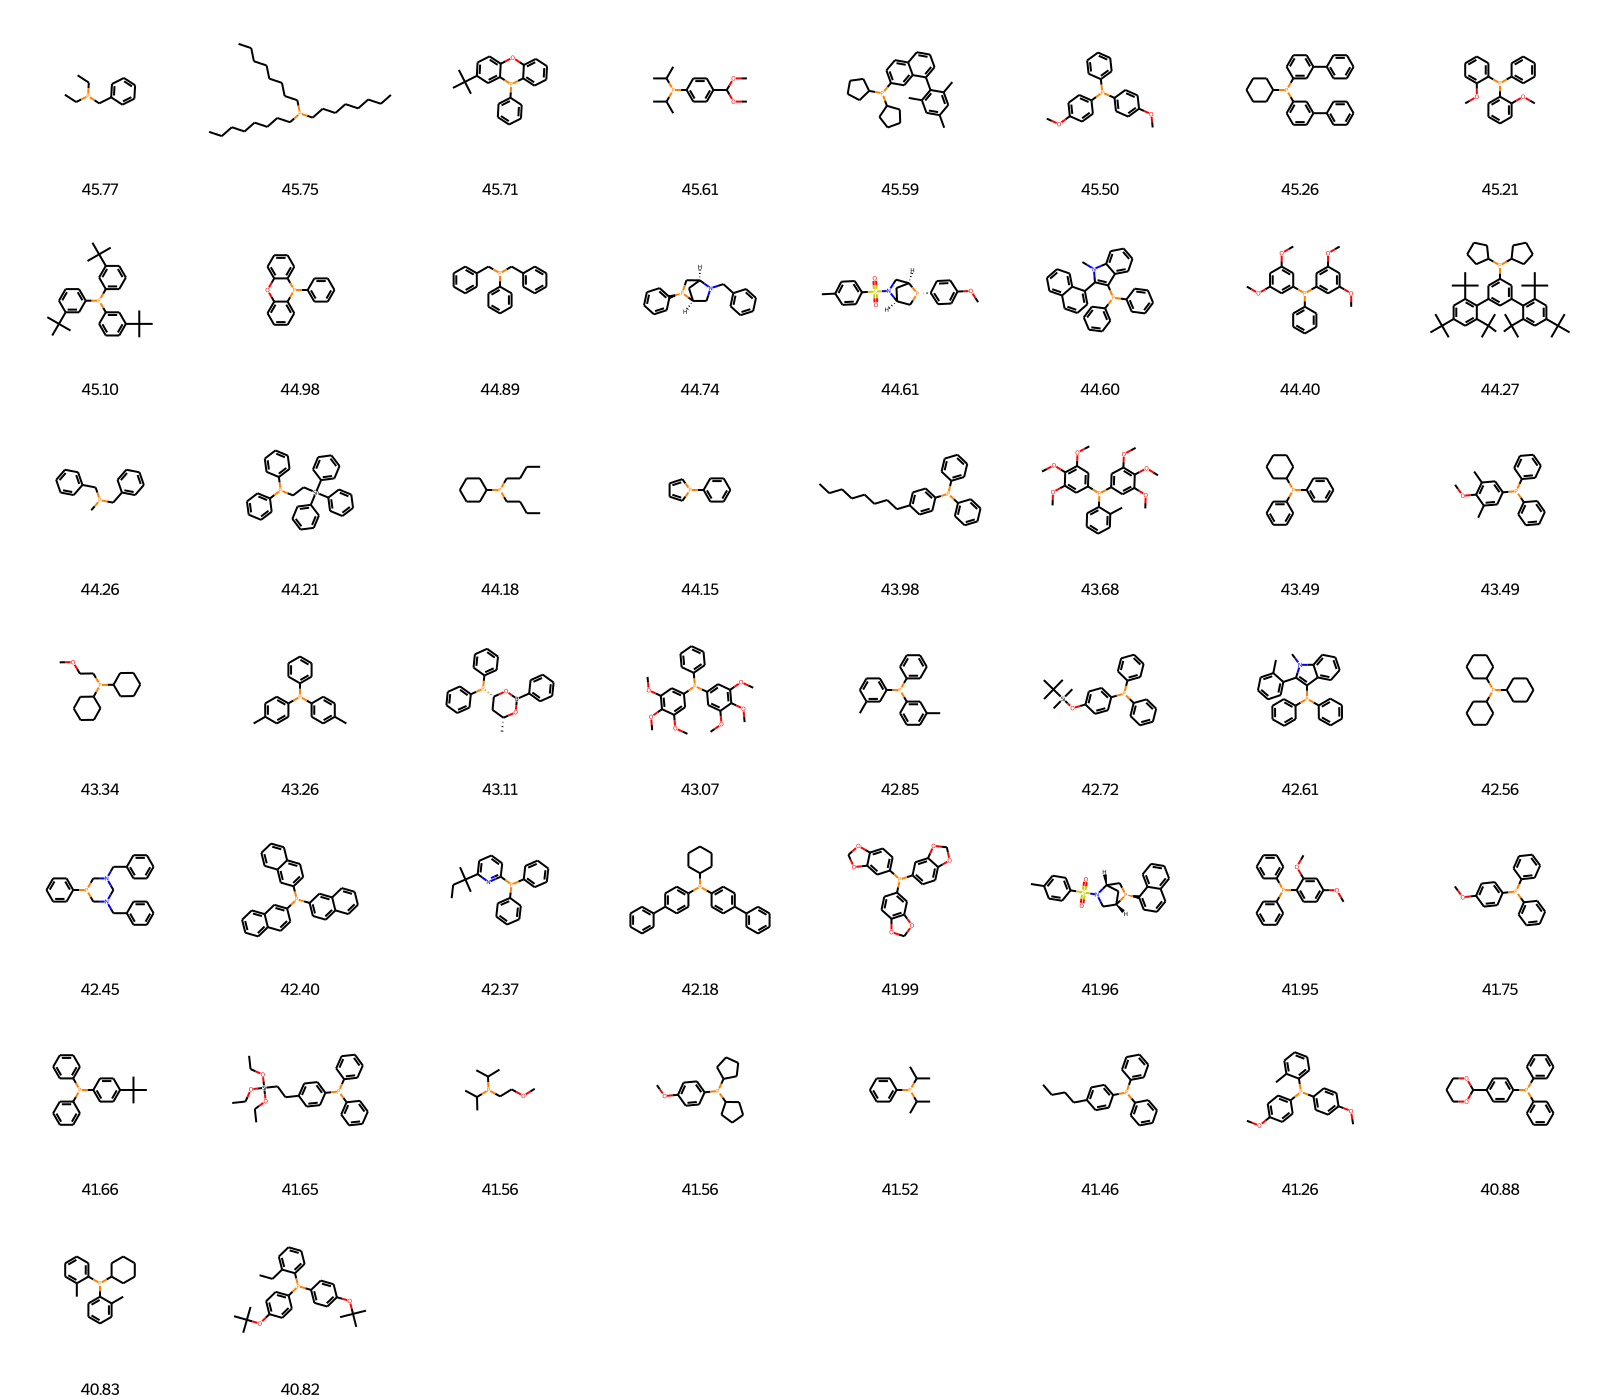

In [92]:
mols = [Chem.MolFromSmiles(smi) for smi in df_kraken_remove_functionality_3['SMILES'][150:]]
Draw.MolsToGridImage(mols, molsPerRow=8, subImgSize=(200, 200), legends=[f"{x:.2f}" for x in df_kraken_remove_functionality_3['y_pred'][150:]])

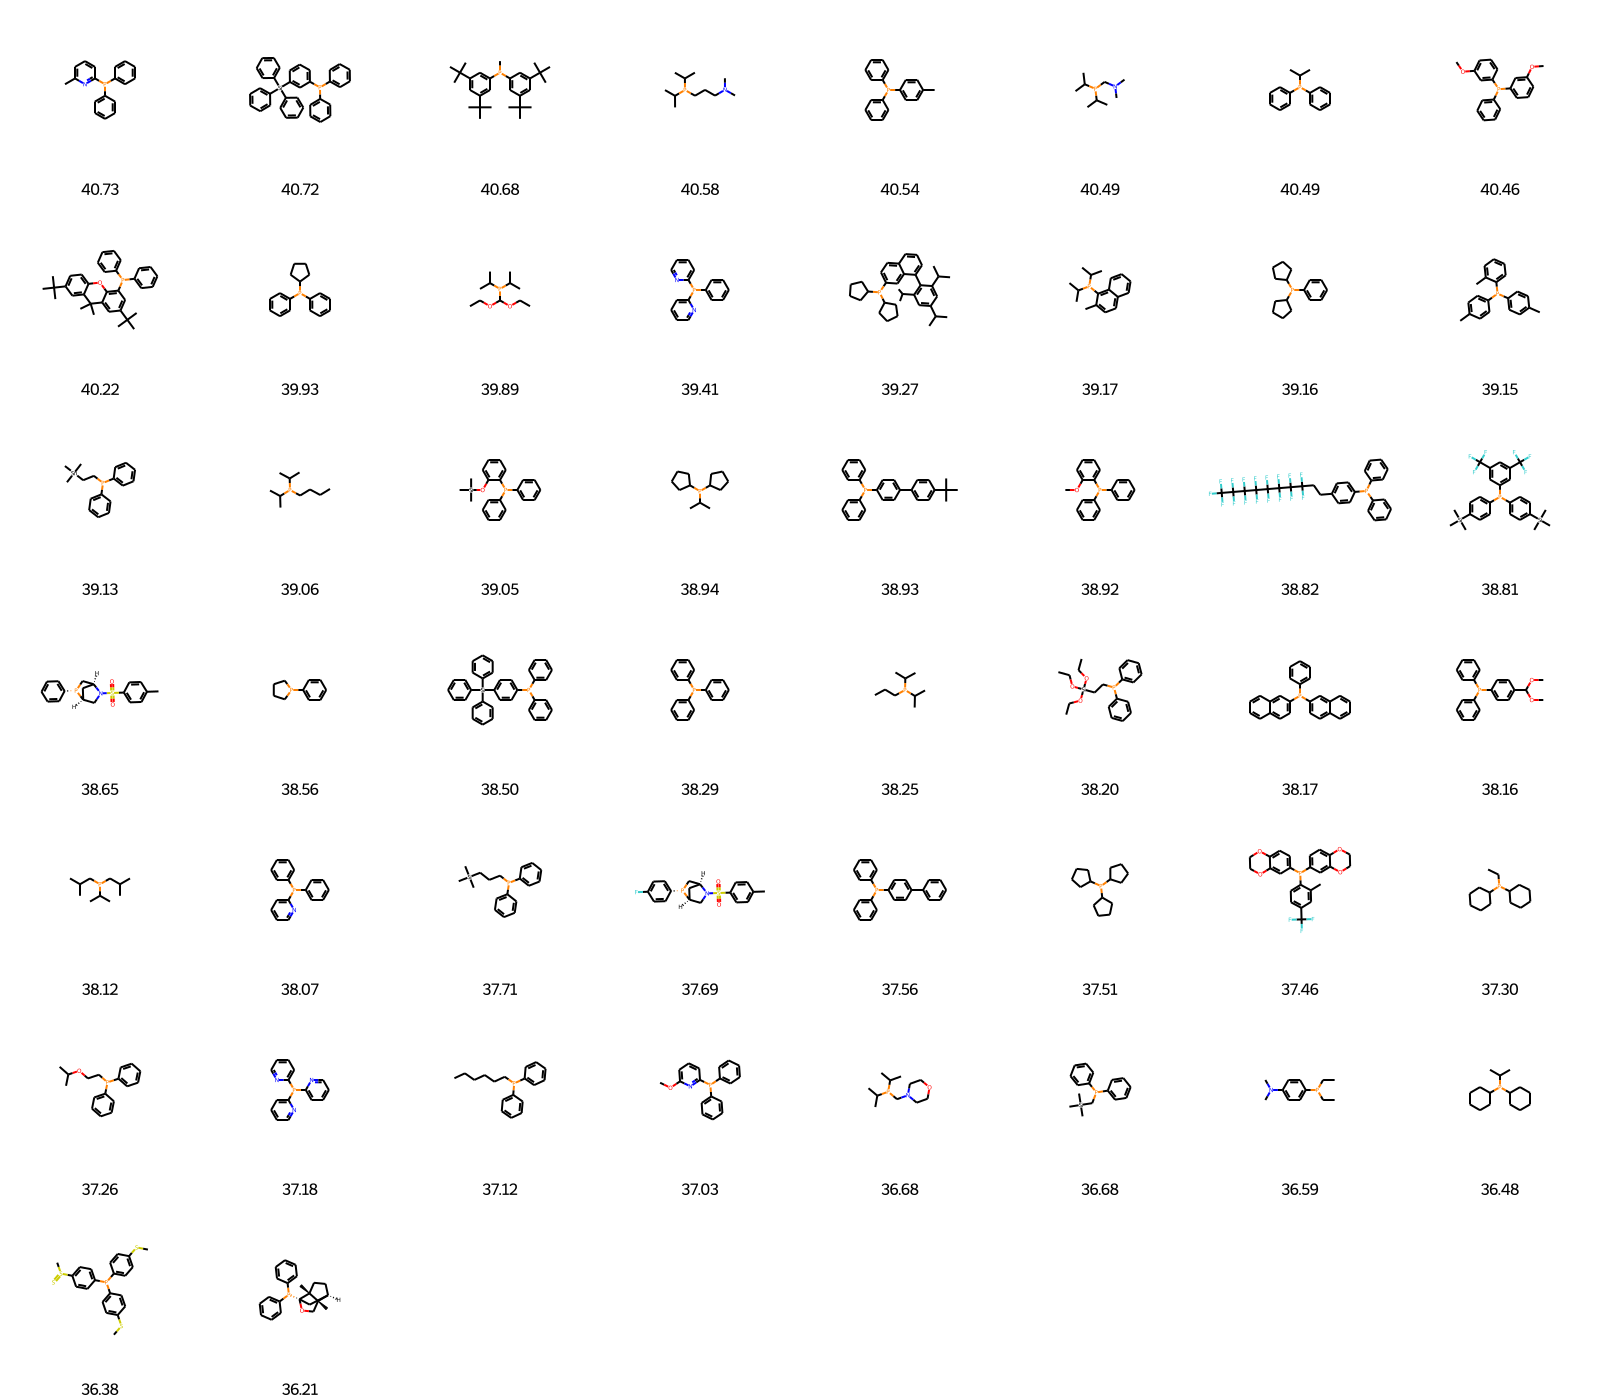

In [93]:
mols = [Chem.MolFromSmiles(smi) for smi in df_kraken_remove_functionality_3['SMILES'][200:]]
Draw.MolsToGridImage(mols, molsPerRow=8, subImgSize=(200, 200), legends=[f"{x:.2f}" for x in df_kraken_remove_functionality_3['y_pred'][200:]])

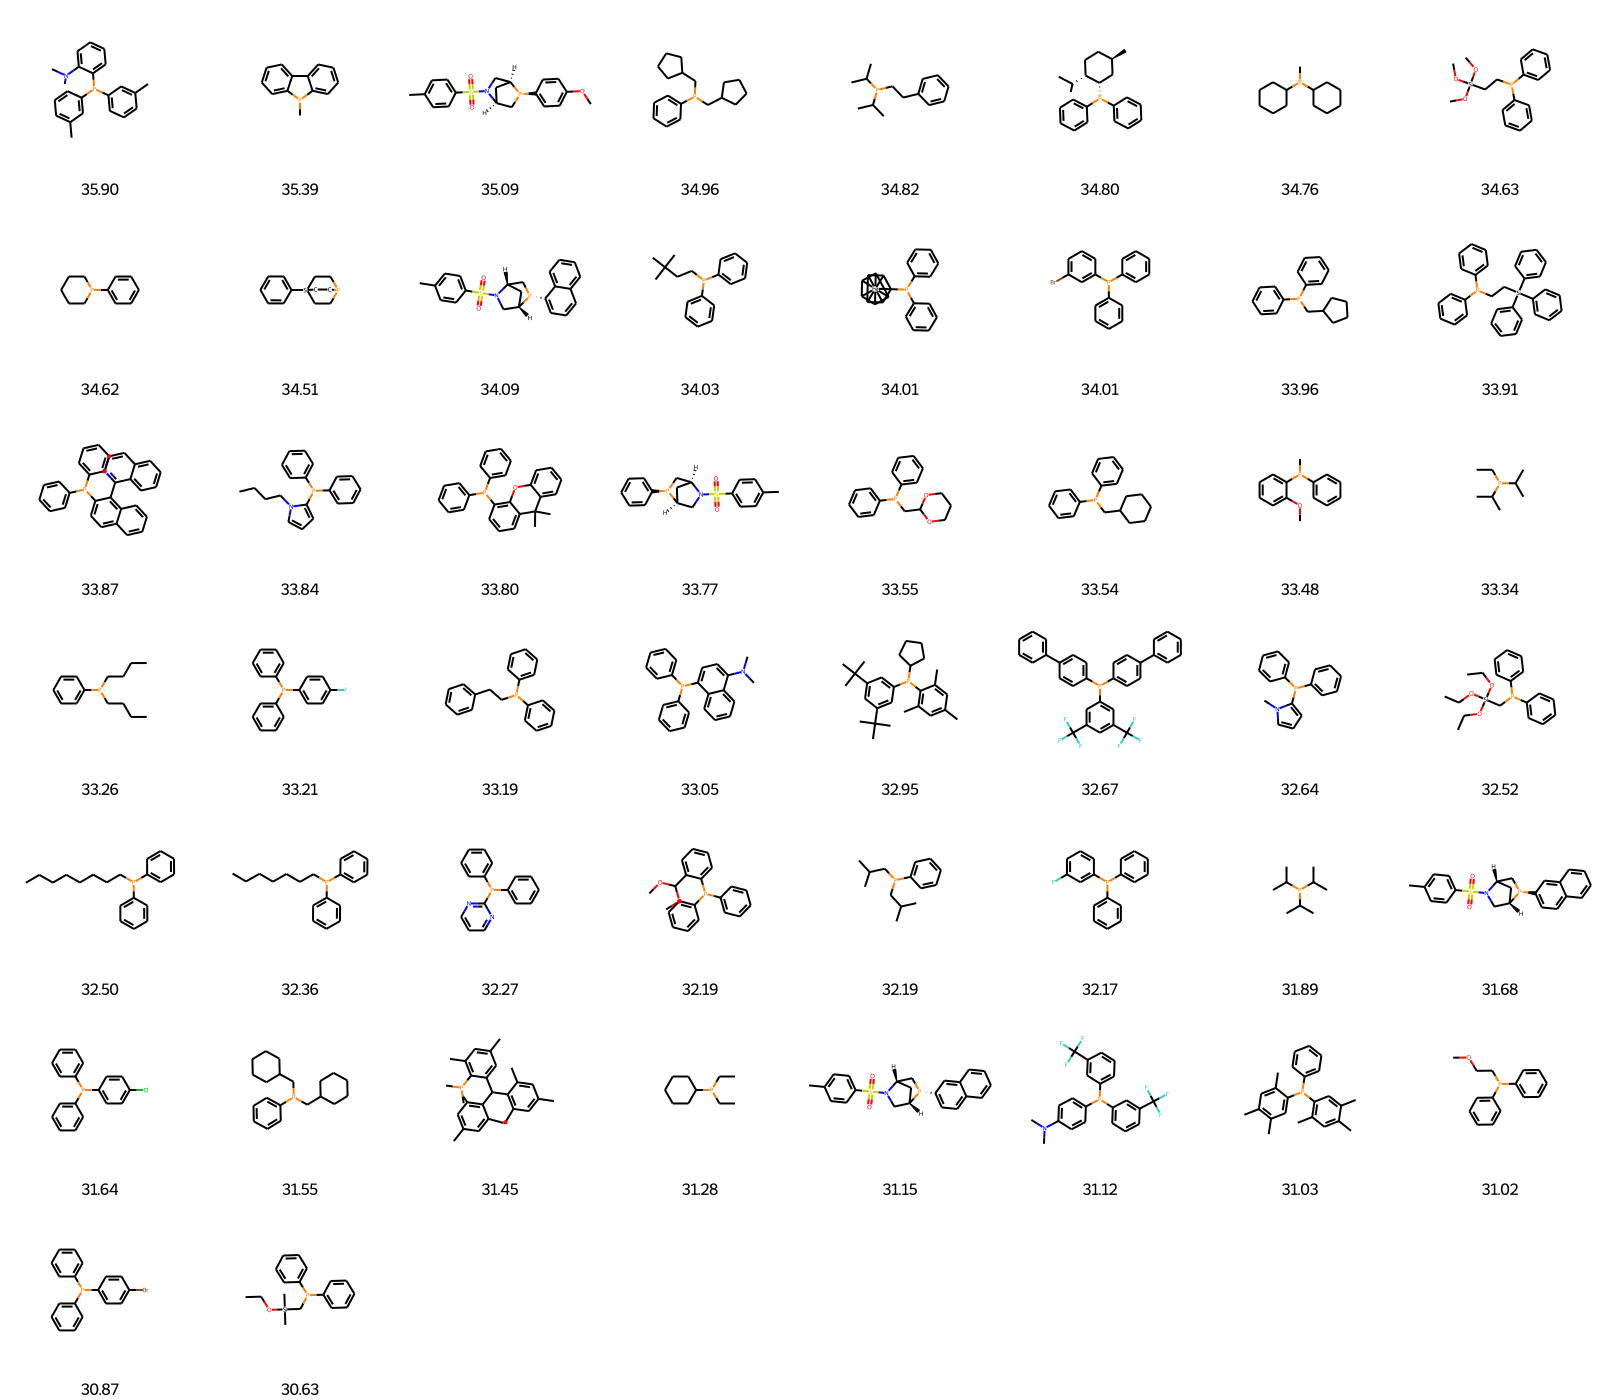

In [94]:
mols = [Chem.MolFromSmiles(smi) for smi in df_kraken_remove_functionality_3['SMILES'][250:]]
Draw.MolsToGridImage(mols, molsPerRow=8, subImgSize=(200, 200), legends=[f"{x:.2f}" for x in df_kraken_remove_functionality_3['y_pred'][250:]])

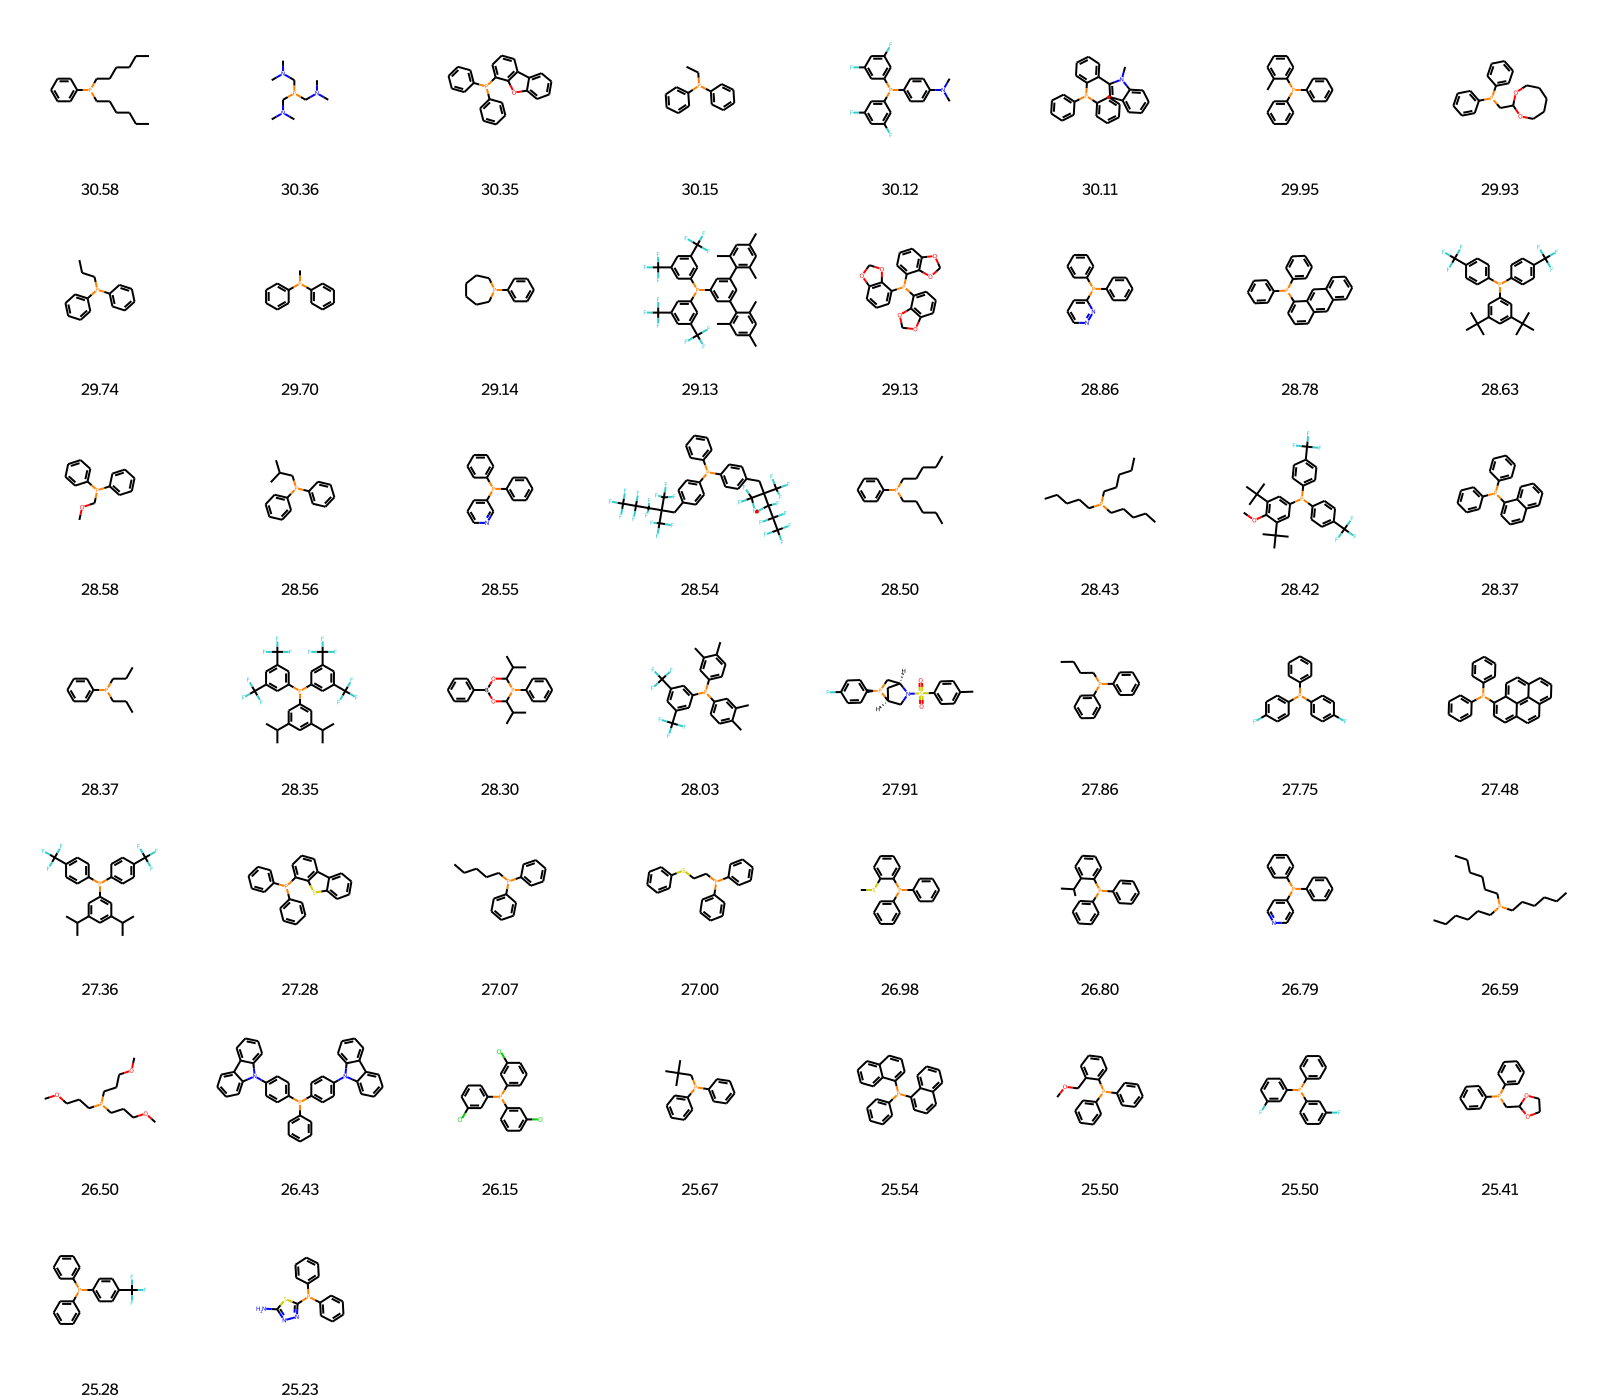

In [95]:
mols = [Chem.MolFromSmiles(smi) for smi in df_kraken_remove_functionality_3['SMILES'][300:]]
Draw.MolsToGridImage(mols, molsPerRow=8, subImgSize=(200, 200), legends=[f"{x:.2f}" for x in df_kraken_remove_functionality_3['y_pred'][300:]])

In [96]:
# find ligand with ID = 471
df_kraken_remove_functionality_3.loc[df_kraken_remove_functionality_3['ID']==471]

,x32,x83,x23,x102,y_pred,ID,SMILES,label
324,-0.247757,0.854749,-0.592724,0.218738,34.796541,471,CC(C)[C@@H]1CC[C@@H](C)C[C@@H]1P(c1ccccc1)c1cc...,Diphenyl
